In [1]:
import numpy as np
import sklearn as sk
import matplotlib.pyplot as plt
from optparse import OptionParser
import datetime
import time
import sys
import os
import gc

In [19]:
class local_log():
    def __init__(self, fields={'1min'  : set(['start_time', 'cnt', 'valid_cnt', 'loss_cnt', 'dup_cnt', 'mis_order_cnt']),
                               '10min' : set(['start_time', 'recv', 'loss', 'dupe', 'ooo', 'end_time'])}):
        self.fields = fields
        self.log = {'1min':{}, '10min':{}}
        return
    
    def read_log(self, path, is_valid=lambda x:True):
        file = open(path, 'r')
        log = file.read().strip('\n').split('\n\n')
        file.close()
        
        for cur_record in log:
            
            # specify type
            cur_record_key = None
            if 'info-1min:' in cur_record:
                cur_record_key = '1min'
                cur_record = cur_record.split('info-1min:')[-1].strip('\n').split('\n')
            elif 'info-10min:' in cur_record:
                cur_record_key = '10min'
                cur_record = cur_record.split('info-10min:')[-1].strip('\n').split('\n')
                assert cur_record[-1] == '-------'
                cur_record = cur_record[:-1]
            else:
                print('Unknow record:')
                print(cur_record)
                raise
            
            # fill up fields
            for field in cur_record:
                field = field.split()
                assert len(field) == 2

                try:
                    record = self.log[cur_record_key][field[0]]
                except:
                    self.log[cur_record_key][field[0]] = []
                    record = self.log[cur_record_key][field[0]]
                
                record.append(float(field[1]))
            
        # check all required fields seen
        for record_key in ['1min', '10min']:
            assert self.fields[record_key].intersection(self.log[record_key].keys()) == self.fields[record_key]


class local_sys_log():
    def __init__(self, skip_topic=['uptime']):
        self.init_field = lambda: {'time':[], 'val':[]}
        self.skip_topic = skip_topic
        self.log = {}
        return
    
    def __skip(self, cur_topic):
        for i in self.skip_topic:
            if cur_topic.startswith(i):
                return True
        return False
    
    def read_log(self, path):
        with open(path, 'r') as file:
            for line in file:
                try:
                    line = line.split()                    

                    time = int(float(line[0]))
                    
                    topic = line[1] # matching $SYS/broker/.* pattern
                    assert topic.startswith('$SYS/broker/')
                    topic = '/'.join(topic.split('/')[2:])
                    if self.__skip(topic): continue
                    
                    msg  = float(line[-1][2:-1])
                    
                    # insert into field
                    try:
                        record = self.log[topic]
                    except:
                        self.log[topic] = self.init_field()
                        record = self.log[topic]
                    record['time'].append(time)
                    record['val'].append(msg)
                        
                except:
                    print('skip:', line)

class online_log():
     def __init__(self):
            return

def normlised(target, tar_max=None, tar_min=None):
    target  = np.array(target)
    if tar_max == None:
        tar_max = target.max()
    if tar_min == None:
        tar_min = target.min()
    rnt = (target-target.min())/(target.max()-target.min()) * (tar_max - tar_min) + tar_min
    rnt[np.where(rnt!=rnt)] = 0
    return rnt

def get_qos_plot(log, time_key, val_key, std_qos, ax=None, norm=True, mut_T=0, joint=True, 
                 qos_list=['q0','q1','q2']):
    if ax is None:
        ax = plt
    for qos in qos_list:
        if mut_T == 0:
            start_time_list = log[qos].log[time_key]['start_time']
            val_list  = log[qos].log[time_key][val_key]
        else:
            start_time_list = log[qos].log[time_key]['start_time'][:mut_T]
            val_list  = log[qos].log[time_key][val_key][:mut_T]
        if norm:
            val_list = normlised(val_list, 
                                 tar_max=max(log[std_qos].log[time_key][val_key]),
                                 tar_min=min(log[std_qos].log[time_key][val_key]))
        assert all(x<=y for x, y in zip(start_time_list, start_time_list[1:]))
        
        ax.plot(start_time_list, val_list, label=qos)
        if not joint:
            ax.legend()
            ax.show()
    ax.legend()

In [5]:
log_dir = './Log/'
log = {'q0':local_log(), 'q1':local_log(), 'q2':local_log(), 'sys':local_sys_log()}

In [6]:
# read in logs
for filename in sorted(os.listdir(log_dir), key=lambda filename: filename.split('_')[-1]):
    print(filename)
    cur_file_path = log_dir+filename
    filename = filename.split('_')
    
    topic = filename[0]
    qos = 'q'+filename[1]
    if topic == 'fast':
        log[qos].read_log(cur_file_path)

    elif topic == 'SYS':
        log['sys'].read_log(cur_file_path)
    gc.collect()

fast_1_1526728668
SYS_2_1526728668
skip: ['sucessfully', 'subscribe', '$SYS/broker/#']
fast_0_1526728668
fast_2_1526728668
SYS_2_1526885995
skip: ['sucessfully', 'subscribe', '$SYS/broker/#']
skip: ['disconnect', 'time', '1526913369.060653']
skip: ['Unexpected', 'disconnection:', 'rc', '=', '1']
skip: ['log:']
skip: ['sucessfully', 'subscribe', '$SYS/broker/#']
skip: ['1526940981.9964345', '$SYS/broker/timestamp', "b'2018-05-18", "01:30:25+0000'"]
wire_shark


In [7]:
# print fields
for qos in ['q0', 'q1', 'q2']:
    print(qos+':')
    print('1min ', ', '.join(log[qos].log['1min'].keys()))
    print('10min', ', '.join(log[qos].log['10min'].keys()))
    print()
print('sys:')
for sys_topic in log['sys'].log.keys():
    print(sys_topic)

q0:
1min  cnt, valid_cnt, loss_cnt, dup_cnt, mis_order_cnt, cur_val, newest_T, start_time, max_T
10min recv, loss, dupe, ooo, start_time, max_T, end_time

q1:
1min  cnt, valid_cnt, loss_cnt, dup_cnt, mis_order_cnt, cur_val, newest_T, start_time, max_T
10min recv, loss, dupe, ooo, start_time, max_T, end_time

q2:
1min  cnt, valid_cnt, loss_cnt, dup_cnt, mis_order_cnt, cur_val, newest_T, start_time, max_T
10min recv, loss, dupe, ooo, start_time, max_T, end_time

sys:
version
clients/total
clients/maximum
clients/inactive
clients/disconnected
clients/active
clients/connected
clients/expired
load/messages/received/1min
load/messages/received/5min
load/messages/received/15min
load/messages/sent/1min
load/messages/sent/5min
load/messages/sent/15min
load/publish/dropped/1min
load/publish/dropped/5min
load/publish/dropped/15min
load/publish/received/1min
load/publish/received/5min
load/publish/received/15min
load/publish/sent/1min
load/publish/sent/5min
load/publish/sent/15min
load/bytes/recei

In [34]:
sys_focused_topics = ['load/publish/dropped/5min', # avg publish msg dropped 
                      'load/messages/sent/5min',  # avg publish msg sent
                      'load/messages/received/5min', # avg msg received
                      'load/bytes/sent/5min',  # avg bytes sent
                      'load/bytes/received/5min', # avg bytes received
                      'load/connections/5min', # avg CONNECT packet received
                      'clients/connected', # avg active client
                      'heap/current', 'heap/maximum', # size of heap mem 
                      'messages/stored', # msg currently held in mem
                      'publish/messages/dropped', # total msg dropped due to queue limit
                      'retained' # total msg currently retained
                     ]
qos_time_key = '1min'
qos_val_key  = 'cnt'
qos_std      = 'q1'
plot_dir = './Report/plots/loss_cnt/'

In [36]:
for qos in ['q0', 'q1', 'q2']:
    print(max(log[qos].log[qos_time_key][qos_val_key]), 
          min(log[qos].log[qos_time_key][qos_val_key]),
          np.array(log[qos].log[qos_time_key][qos_val_key]).mean())
    
# valid cnt
# 143113.0 29.0 5842.715126545027
# 70664.0 1096.0 4620.315201411349
# 32109.0 927.0 2203.0105944673337

143113.0 29.0 5842.715126545027
75987.0 1126.0 4809.294325198471
38095.0 927.0 2557.403472630959


In [22]:
mut_T = 139
for qos in ['q0', 'q1', 'q2']:
    print(min(np.where(np.array(log[qos].log[qos_time_key]['start_time'])>1526811877)[0]))

139
139
139


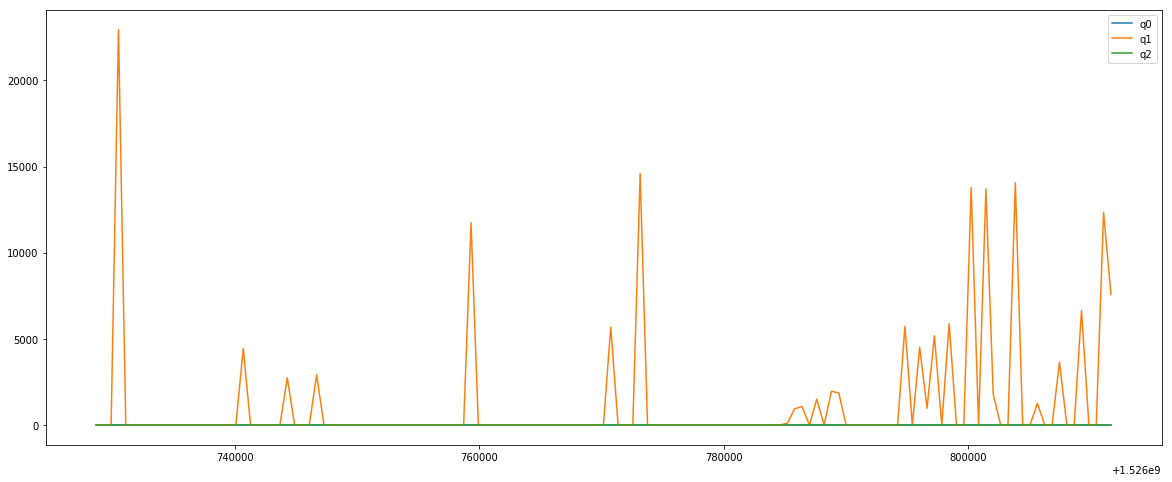

0.2217873450750163 22939.123783454987
44365.64 181147.7


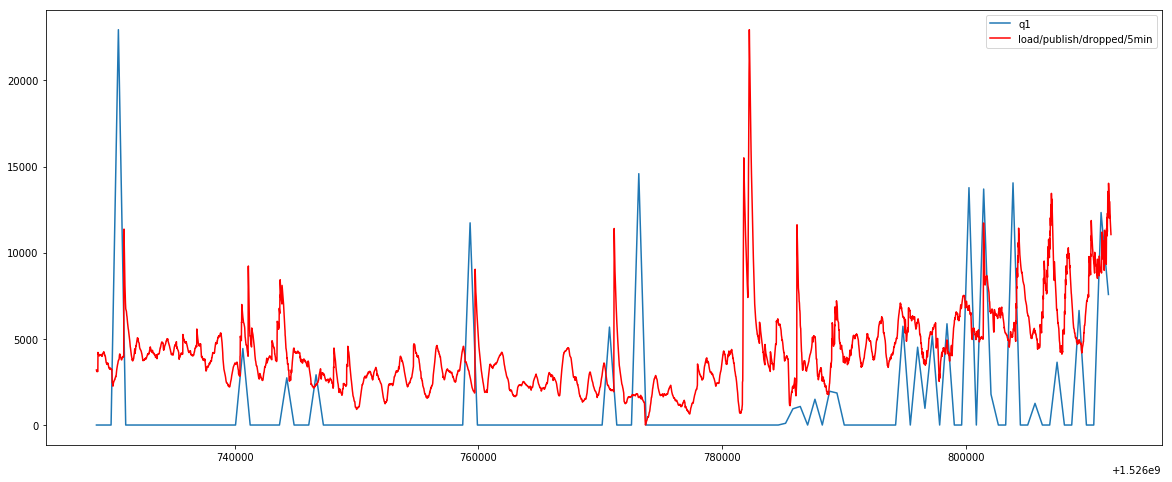

78486.48 199636.44


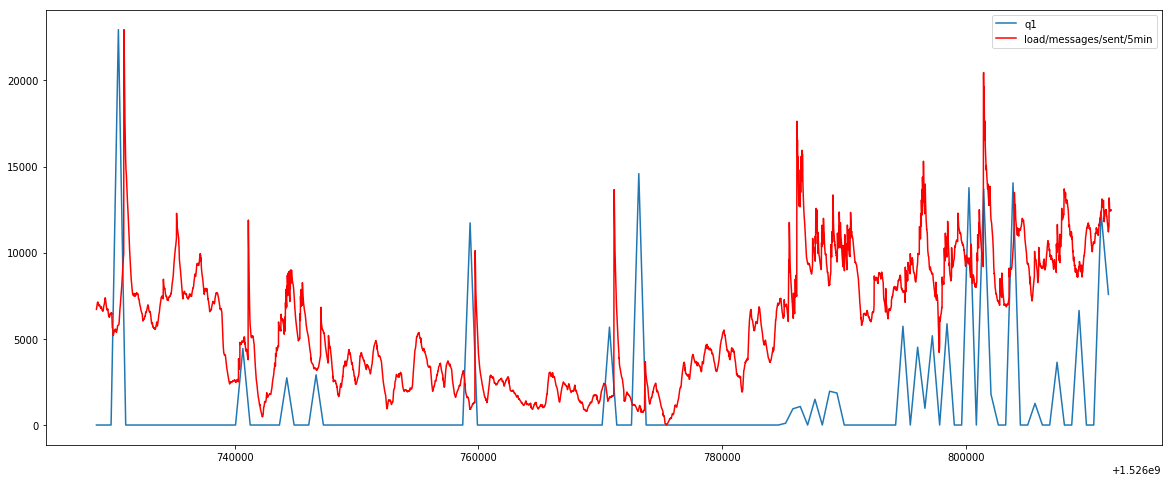

51969.5 108757.09


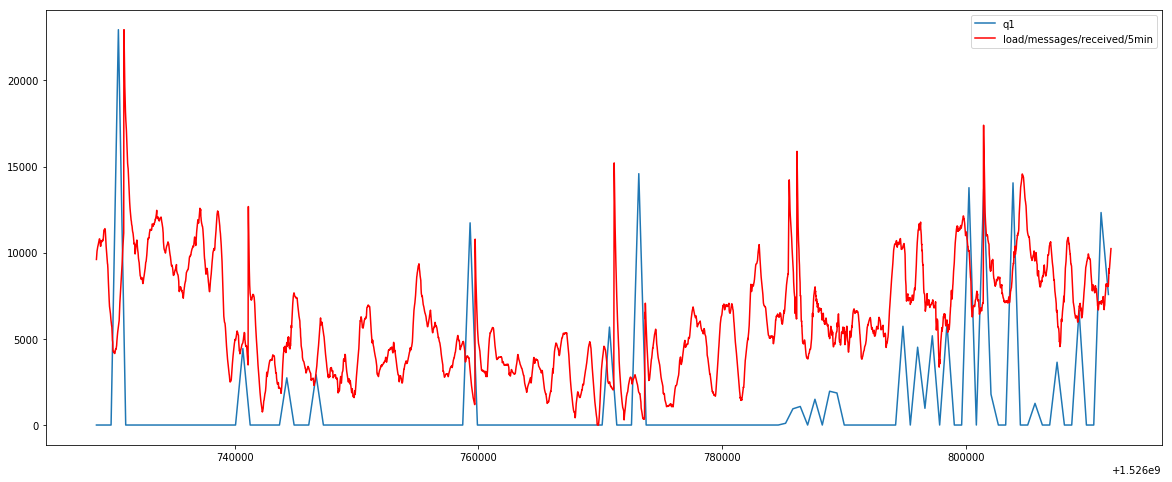

1467449.83 5248979.98


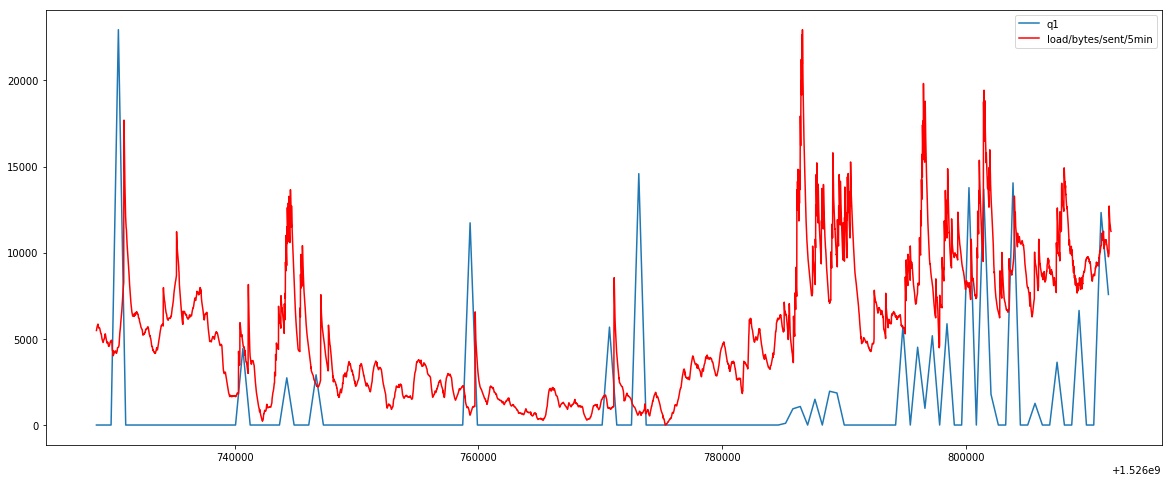

572792.06 1188903.87


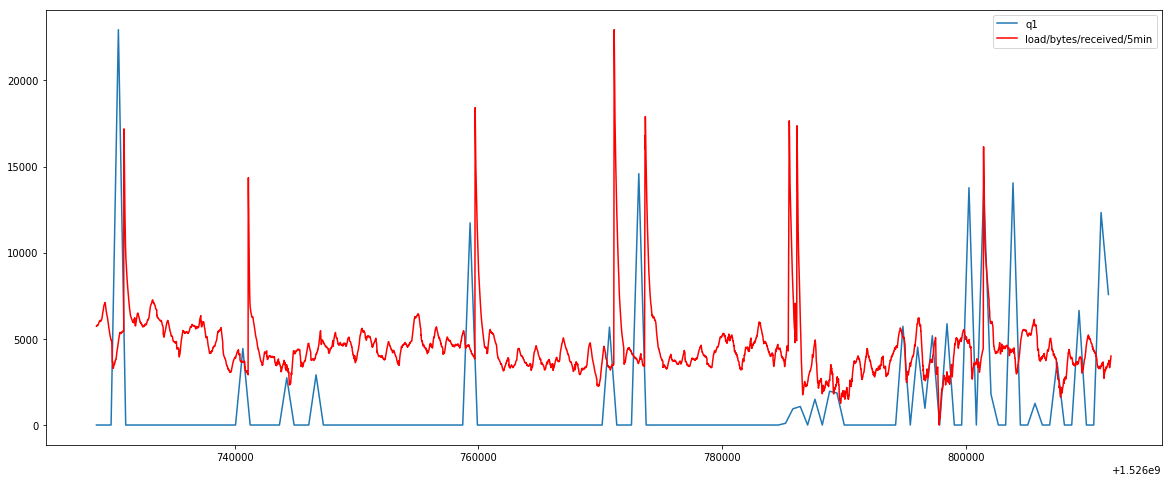

0.7 536.04


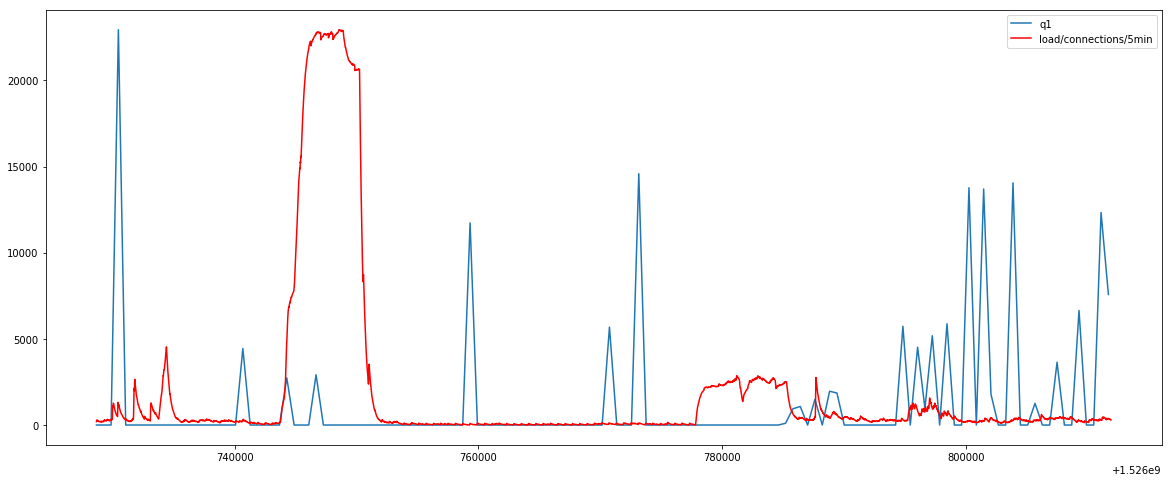

15.0 41.0


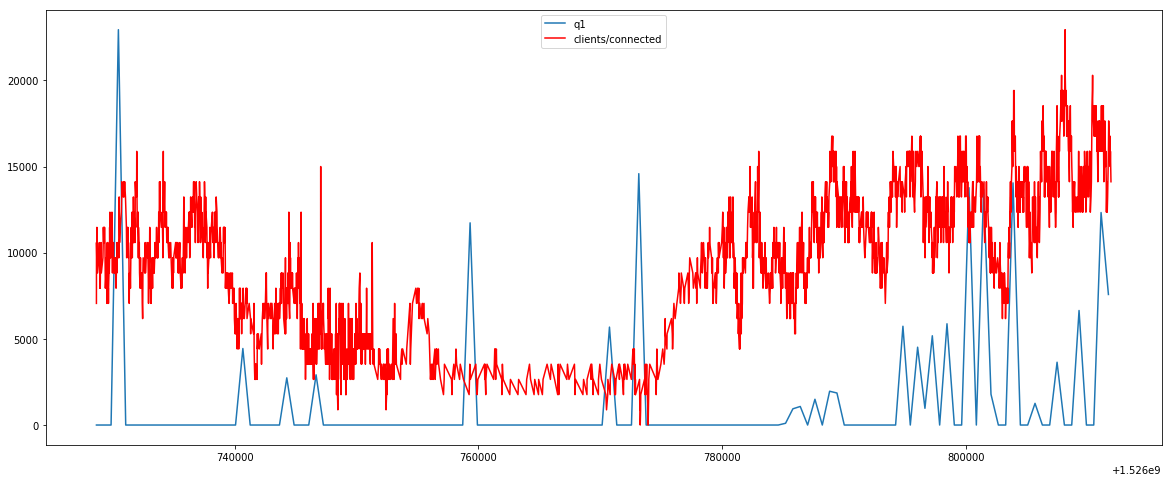

41935448.0 51596968.0


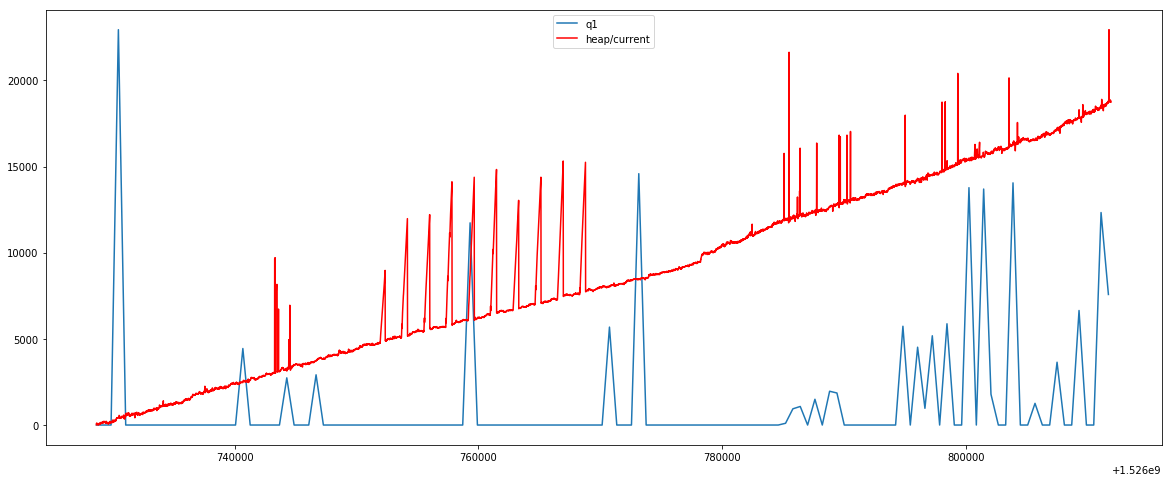

43256736.0 51716440.0


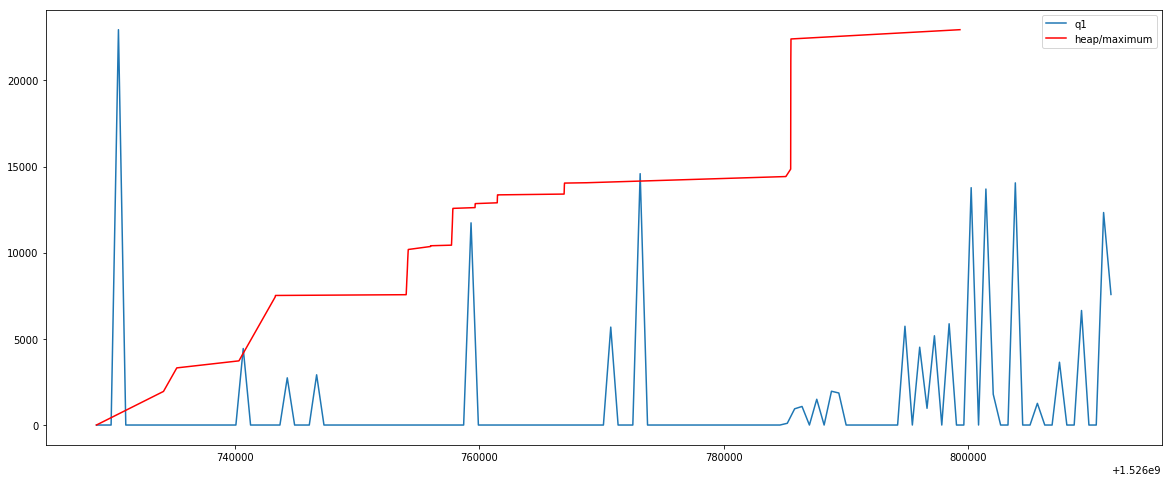

129431.0 141303.0


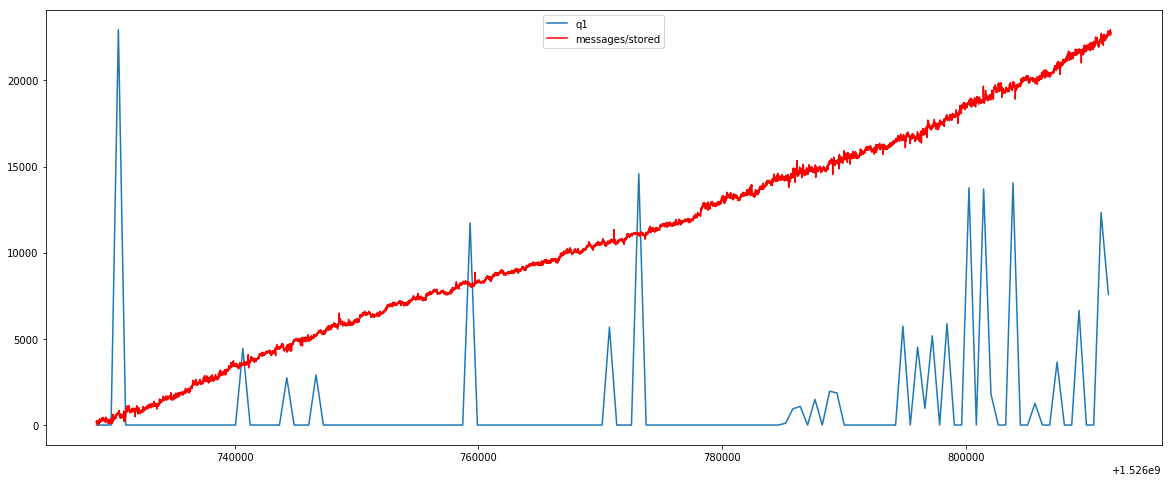

100335512.0 196610256.0


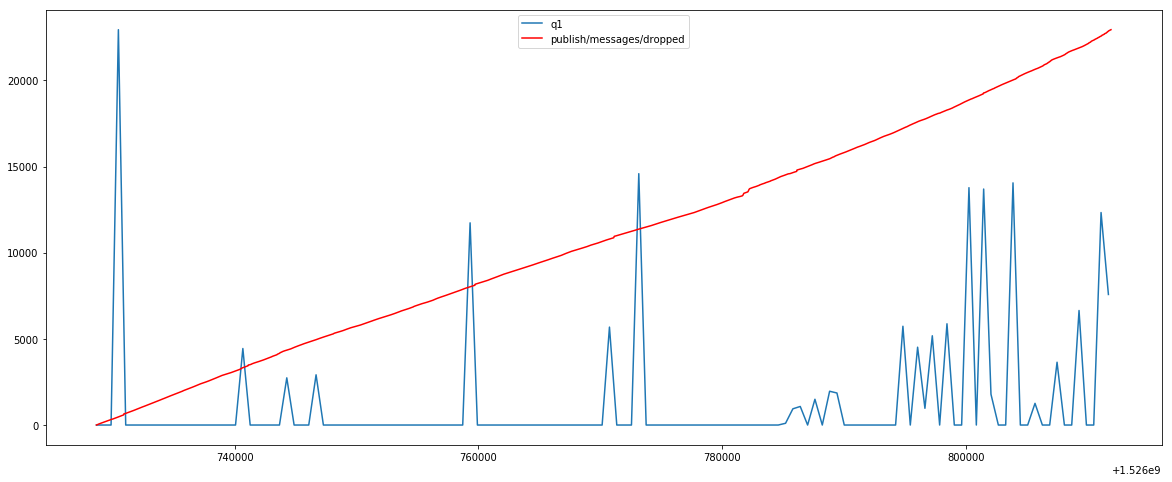

36760.0 45260.0


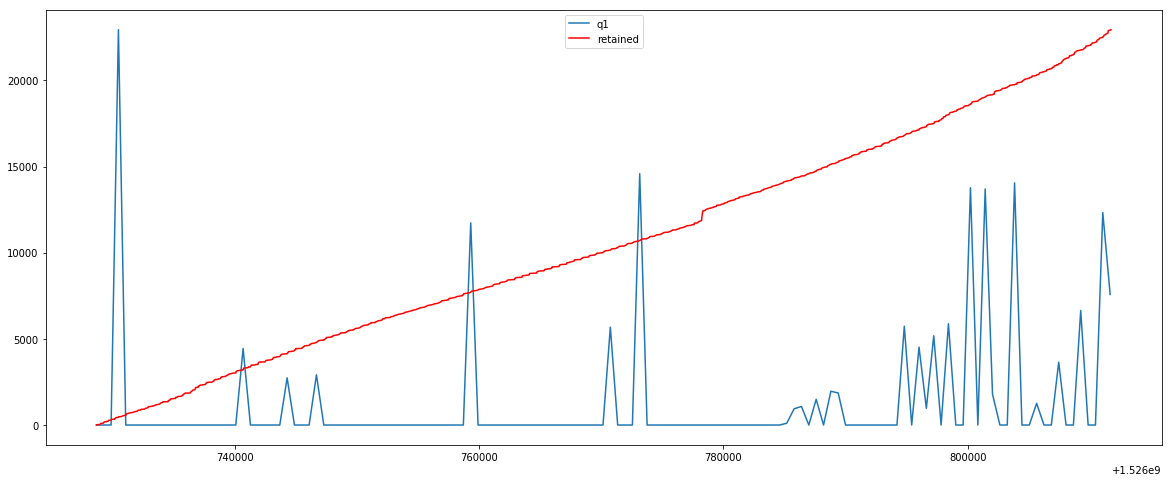

time span: from 2018-05-19 21:17:50 to 2018-05-20 20:22:14


In [30]:
plt.close('all')
plt.figure(figsize=(20,8))
get_qos_plot(log, qos_time_key, qos_val_key, qos_std, norm=False, mut_T=mut_T, joint=True)
plt.legend()
plt.savefig(plot_dir+qos_val_key, bbox_inches='tight', transparent=True)
plt.show()


qos_list = ['q1']
qos_std_max = max(log[qos_std].log[qos_time_key][qos_val_key][:mut_T])
qos_std_min = min(log[qos_std].log[qos_time_key][qos_val_key][:mut_T])
print(qos_std_min, qos_std_max)
for sys_topic in sys_focused_topics:
    plt.figure(figsize=(20,8))
    get_qos_plot(log, qos_time_key, qos_val_key, qos_std, norm=False, mut_T=mut_T, joint=True, qos_list=qos_list)
    
    sys_record = log['sys'].log[sys_topic]
    time_list = np.array(sys_record['time'])
    sys_mut_T = np.where(time_list>1526811877)[0].min()
    
    time_list = time_list[:sys_mut_T]
    val_list  = sys_record['val'][:sys_mut_T]
    print(min(val_list), max(val_list))    
    val_list  = normlised(val_list, tar_max=qos_std_max, tar_min=qos_std_min)    
    
    plt.plot(time_list[:sys_mut_T], val_list[:sys_mut_T], label=sys_topic, c='r')
    plt.legend()
    plt.savefig(plot_dir+qos_val_key+'-'+sys_topic.replace('/','_'), bbox_inches='tight', transparent=True)
    plt.show()
    
print('time span:',
      'from', datetime.datetime.fromtimestamp(int(time_list[0])).strftime('%Y-%m-%d %H:%M:%S'),
      'to', datetime.datetime.fromtimestamp(int(time_list[-1])).strftime('%Y-%m-%d %H:%M:%S'))


In [ ]:
datetime.datetime.fromtimestamp(1526811877).strftime('%Y-%m-%d %H:%M:%S')

In [ ]:
# 179, 1649]),)
start_time_list[175:185]